<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/Decision_Tree_with_reduced_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree with Reduced Features with PCA, Manifold Learning, MDS, t-SNE, LDA and Autoencoder

in this notebook I am going to reduce the number of features by the mentioned methods and then I will feed these data with lower feaures to a Decision Tree to classify the signals.

The signals will be in the frequency domain which is produced in 'ANN for FFT' notebook.
I will try to use random forests to gain higher accuracy and f1.


Since the Decision Trees are very low efficient for higher number of features, so the Feature Reductoin methods are necessarry. Since every method is good from different aspect, this is why I use different methods for feature reduction.

In [1]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding, SpectralEmbedding



# Data Prepartion

In [2]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation


Cloning into 'EEG-computation'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (389/389), done.
remote: Compressing objects: 100% (385/385), done.
remote: Total 389 (delta 20), reused 351 (delta 2), pack-reused 0
Receiving objects: 100% (389/389), 579.94 MiB | 15.23 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Checking out files: 100% (341/341), done.
/content/EEG-computation


In [0]:


disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])

        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
        
        
data = {"N":channels_normal,
      "D":channels_disorder}



In [0]:
def New_Data_Generator_N():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['N'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['N'].append(new_data[person])
        person += 1

    
def New_Data_Generator_D():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['D'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['D'].append(new_data[person])
        person += 1

In [0]:
New_Data_Generator_N()
New_Data_Generator_D()

In [7]:


n_D , n_N = len(data['D']), len(data['N'])

n_D, n_N

(631, 567)

In [8]:
index = np.arange(0,512*30)
f = np.linspace(0,512,512*30)
f_max = f[len(f[f<120])]
ind_min = 2
ind_max = list(index[f==f_max])[0]
f_min = f[ind_min]

print(f_min, f_max, ind_min, ind_max)


sam_FT = np.abs(fft(data['D'][50][7]))

# The 50 Htz noise elimination information

f_45 = f>45
f_55 = f<55
f_bar = f<45

for i in range(f.shape[0]):
  f_bar[i] = f_45[i] and f_55[i]
  
  
noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
noise_index = list(index[f==noise])[0] # in range 0, 512*30
del_domain = 40
del_range = [noise_index + i for i in range(-del_domain,del_domain)]
print(noise, noise_index)

0.06667100722703301 120.00781300865941 2 3600
50.13659743472882 1504


In [9]:
sam_FT[list(f<55) or list(f>45)].shape

(1650,)

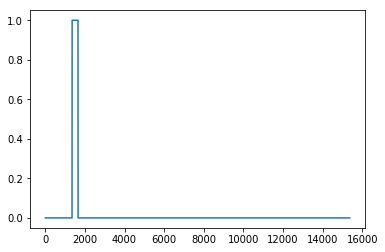

In [10]:
plt.plot(f_bar)

In [0]:
f = np.linspace(0,512,512*30)[ind_min:ind_max]

In [0]:
normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


FT = {'D':disorder,
     'N':normal}

from numpy.fft import fft

for d in range(n_D):
    for i in range(19):
        
        FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
        FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
        FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])
    
for n in range(n_N):
    for i in range(19):
        FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
        FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
        FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])
        

    FT['N'] = np.array(FT['N'])
    FT['D'] = np.array(FT['D'])

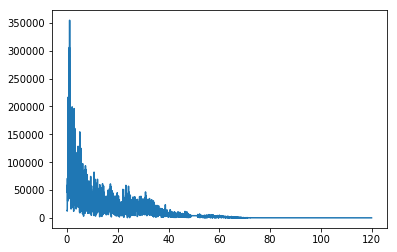

In [13]:
plt.plot(f, FT['N'][56][8])

In [0]:
FT_matrix_N = FT['N']
FT_matrix_D = FT['D']

temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
temp_N = FT_matrix_N.reshape((FT_matrix_N.shape[0],FT_matrix_N.shape[2],FT_matrix_N.shape[1]))
#or d in range(FT_matrix.shape[0]):
scaler = StandardScaler()


In [0]:
for n in range(FT_matrix_N.shape[0]):
  temp_N[n]= scaler.fit_transform(FT_matrix_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)

In [0]:
for n in range(FT_matrix_N.shape[0]):
  FT_matrix_N[n]= scaler.fit_transform(temp_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  FT_matrix_D[d]= scaler.fit_transform(temp_D[d].T)

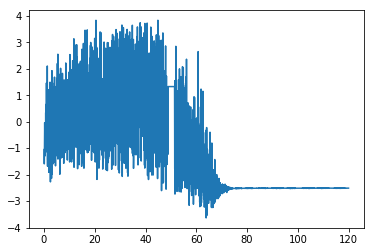

In [17]:
plt.plot(f,FT_matrix_D[8,8])

In [18]:
FT_matrix_D.shape, FT_matrix_N.shape

((631, 19, 3598), (567, 19, 3598))

In [0]:
# normal is 1 and disorder is 0
Data = np.vstack((FT_matrix_N, FT_matrix_D))
target = np.hstack((np.ones(FT_matrix_N.shape[0]), np.zeros(FT_matrix_D.shape[0])))

In [0]:
X, y = shuffle(Data, target)

#PCA

In [0]:
pca = PCA(n_components = 1)
X = X.reshape(X.shape[0],-1)

In [31]:
X.shape

(1198, 68362)

In [0]:
X_pca = pca.fit_transform(X)

In [33]:
X_pca.shape

(1198, 1)

In [0]:


n=10
pca = PCA(n)
pca.fit(X)
data = pca.transform(X)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
#labels = ["PC" + str(i) for i in range (1,len(per_var)+1)]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)
print('the scree plot of the features is :')
#ax.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
ax.plot(range(1,len(per_var)+1),per_var,'k--',linewidth=4,)



In [29]:
X.shape

(1198, 68362)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,y)

# Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=2)

In [41]:
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
Y_predict = model.predict(X_test)
cnfmatrix = confusion_matrix(y_test,Y_predict)
print(cnfmatrix)

[[154   0]
 [  0 146]]


In [43]:
clf_report = classification_report(y_test, Y_predict)
print(clf_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       154
         1.0       1.00      1.00      1.00       146

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

